## Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
from scipy.stats import norm
import math
import re
# import sidetable
import seaborn as sns
from sklearn.impute import SimpleImputer

## Read in Survey.csv

In [2]:
survey = pd.read_csv("surveydata.csv")
#how many observations
print(survey.SubjectID.count())
#unique ID
print(len(pd.unique(survey['SubjectID'])))
#unique description, 5 questions
print(pd.unique(survey['description']))
#print(max(survey['Unnamed:0']))
survey.head()

5540
37
['Numeric answer for number of hours of sleep for participant on night before the run'
 'Approximate time of day when run was performed'
 'Type of surface (soft, hard, etc) for route that participant ran'
 'General descriptions of running surface conditions (dry, wet, icy, etc)'
 'RPE scale 1-10 of workout difficulty']


,Unnamed: 0,Unnamed: 0.1,description,filename,name,numerical_ans,textual_ans,SubjectID,Year,Date,DataSource
0,0,0,Numeric answer for number of hours of sleep fo...,58_20180811_surveydata.csv,MT Run Follow Up - Previous Nights Sleep (hours),NaN,7.5,58,2018,811,surveydata.csv
1,1,1,Approximate time of day when run was performed,58_20180811_surveydata.csv,MT Run Follow Up - Time of Run,NaN,8:03:00 AM,58,2018,811,surveydata.csv
2,2,2,"Type of surface (soft, hard, etc) for route th...",58_20180811_surveydata.csv,MT Run Follow Up - Surface,NaN,"Hard (sidewalk, asphalt)",58,2018,811,surveydata.csv
3,3,3,General descriptions of running surface condit...,58_20180811_surveydata.csv,MT Run Follow Up - Surface Conditions,NaN,Dry,58,2018,811,surveydata.csv
4,4,4,RPE scale 1-10 of workout difficulty,58_20180811_surveydata.csv,MT Run Follow Up - How Was Your Workout,NaN,3 - Moderate,58,2018,811,surveydata.csv


## We will pick these 2 descriptions:
- 'Numeric answer for number of hours of sleep for participant on night before the run'
- 'RPE scale 1-10 of workout difficulty'

In [3]:
surveydf = survey[(survey.description == 'Numeric answer for number of hours of sleep for participant on night before the run') |
           (survey.description == 'RPE scale 1-10 of workout difficulty')]
print(pd.unique(surveydf['numerical_ans']))
print(pd.unique(surveydf['textual_ans']))


[      nan  7.5       6.        7.25      6.5       7.        0.270833
  5.        0.229167 18.        8.        9.5       5.5       5.75
  8.5       4.        6.25      0.173611]
['7.5' '3 - Moderate' '8' '4 - Somewhat Hard' '7.50' '6.5' '7.00' '6' '7'
 '5' '2 - Easy' '6.5 hours' nan '7.5 hrs, good sleep !' '9.00' '6.50'
 '8.50' '8 hours 45 minutes' '6hours 41 minutes' '5 - Hard'
 '8 hours 20 minutes' '7 hours 13 minutes' '6 hours' '7 hours 21 minutes'
 '6:40' '5.5' '0.313888889' '7 hours, 56 minutes' '9 hours' '7 hours'
 '7 - Very Hard' '7 hours 50 minutes' '7 hours 15 minutes' '7.30'
 '6 hours 39 minutes' '6 hours 10 minutes' '6 hours 16 minutes'
 '8 hours 51 mnutes' '6 hours 48 minutes' '7 hours 12 minutes'
 '7 hours 49 minutes' '6 hours 13 minutes' '8 hours 30 minutes'
 '5hours 32minutes' '6 hours 34 minutes' '3' '1 - Very, Very Easy'
 '8 hours' '0.243055556' '5 hours 57 minutes' '7 hours 43 minutes'
 '5 hrs 56 minutes' '7.75' '7hours 10minutes' '5.75' '7 hours 20 minutes'
 '5.67'

In [4]:
#Lets clean this data

#Drop 2 first columns
surveydf.drop(surveydf.columns[[0, 1]], axis=1, inplace=True)

C:\Users\Mark\anaconda3\envs\data624_hw2-Ly-Mark\lib\site-packages\pandas\core\frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [5]:
#Create key variables

#For a unique survey, we can make a key variable concatenating  (SubjectID, Year and Date)
cols = ['SubjectID', 'Year', 'Date'] #This key variable might help to find same observation in the garmin database
surveydf['key'] = surveydf[cols].apply(lambda row: '_'.join(row.values.astype(str)), axis=1)

#For a unique observation in the survey, we can make a key2 with (SubjectID, Year, Date and description)
cols2 = ['SubjectID', 'Year', 'Date','description']
surveydf['key2'] = surveydf[cols2].apply(lambda row: '_'.join(row.values.astype(str)), axis=1)

#Count how many possible mistakes, duplicate observations may have
print(surveydf[surveydf.duplicated(subset=['key2'],keep=False)].SubjectID.count())
#53 from 5540 obs is not bad

#Lets just look to the first one
key_look = '424_2017_617'
surveydf[surveydf.key == key_look]


26


C:\Users\Mark\AppData\Local\Temp/ipykernel_22516/2771317242.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  surveydf['key'] = surveydf[cols].apply(lambda row: '_'.join(row.values.astype(str)), axis=1)
C:\Users\Mark\AppData\Local\Temp/ipykernel_22516/2771317242.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  surveydf['key2'] = surveydf[cols2].apply(lambda row: '_'.join(row.values.astype(str)), axis=1)


,description,filename,name,numerical_ans,textual_ans,SubjectID,Year,Date,DataSource,key,key2
462,Numeric answer for number of hours of sleep fo...,424_20170617_surveydata.csv,MT Run Follow Up - Previous Nights Sleep (hours),6.0,NaN,424,2017,617,surveydata.csv,424_2017_617,424_2017_617_Numeric answer for number of hour...
466,Numeric answer for number of hours of sleep fo...,424_20170617_surveydata.csv,MT Run Follow Up - Previous Nights Sleep (hours),NaN,6.00,424,2017,617,surveydata.csv,424_2017_617,424_2017_617_Numeric answer for number of hour...


In [6]:
for col in surveydf.columns:
    pct_missing = np.mean(surveydf[col].isnull())
    print('{} - {}%'.format(col, round(pct_missing*100)))

description - 0%
filename - 0%
name - 0%
numerical_ans - 94%
textual_ans - 6%
SubjectID - 0%
Year - 0%
Date - 0%
DataSource - 0%
key - 0%
key2 - 0%


## Split into 2 survey dfs - one for each description:
 Major task is to clean the textual data into numerical data

In [7]:
surveydf1 = surveydf[surveydf.description ==  'RPE scale 1-10 of workout difficulty']
surveydf1['cleaned_column'] = surveydf1['textual_ans'].apply(lambda x: [int(s) for s in x.split() if s.isdigit()][0])
surveydf1['numerical_final_workout'] = surveydf1.numerical_ans.combine_first(surveydf1.cleaned_column)
surveydf1.head()

C:\Users\Mark\AppData\Local\Temp/ipykernel_22516/3543428367.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  surveydf1['cleaned_column'] = surveydf1['textual_ans'].apply(lambda x: [int(s) for s in x.split() if s.isdigit()][0])
C:\Users\Mark\AppData\Local\Temp/ipykernel_22516/3543428367.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  surveydf1['numerical_final_workout'] = surveydf1.numerical_ans.combine_first(surveydf1.cleaned_column)


,description,filename,name,numerical_ans,textual_ans,SubjectID,Year,Date,DataSource,key,key2,cleaned_column,numerical_final_workout
4,RPE scale 1-10 of workout difficulty,58_20180811_surveydata.csv,MT Run Follow Up - How Was Your Workout,NaN,3 - Moderate,58,2018,811,surveydata.csv,58_2018_811,58_2018_811_RPE scale 1-10 of workout difficulty,3,3.0
9,RPE scale 1-10 of workout difficulty,58_20180609_surveydata.csv,MT Run Follow Up - How Was Your Workout,NaN,4 - Somewhat Hard,58,2018,609,surveydata.csv,58_2018_609,58_2018_609_RPE scale 1-10 of workout difficulty,4,4.0
14,RPE scale 1-10 of workout difficulty,58_20180526_surveydata.csv,MT Run Follow Up - How Was Your Workout,NaN,3 - Moderate,58,2018,526,surveydata.csv,58_2018_526,58_2018_526_RPE scale 1-10 of workout difficulty,3,3.0
29,RPE scale 1-10 of workout difficulty,58_20180704_surveydata.csv,MT Run Follow Up - How Was Your Workout,NaN,4 - Somewhat Hard,58,2018,704,surveydata.csv,58_2018_704,58_2018_704_RPE scale 1-10 of workout difficulty,4,4.0
35,RPE scale 1-10 of workout difficulty,58_20180818_surveydata.csv,MT Run Follow Up - How Was Your Workout,NaN,3 - Moderate,58,2018,818,surveydata.csv,58_2018_818,58_2018_818_RPE scale 1-10 of workout difficulty,3,3.0


In [8]:
surveydf1.textual_ans.unique()

array(['3 - Moderate', '4 - Somewhat Hard', '2 - Easy', '5 - Hard',
       '7 - Very Hard', '1 - Very, Very Easy', '6', '8', '9'],
      dtype=object)

In [9]:
surveydf2 = surveydf[surveydf.description ==  'Numeric answer for number of hours of sleep for participant on night before the run']
surveydf2.textual_ans.unique()

array(['7.5', '8', '7.50', '6.5', '7.00', '6', '7', '5', '6.5 hours', nan,
       '7.5 hrs, good sleep !', '9.00', '6.50', '8.50',
       '8 hours 45 minutes', '6hours 41 minutes', '8 hours 20 minutes',
       '7 hours 13 minutes', '6 hours', '7 hours 21 minutes', '6:40',
       '5.5', '0.313888889', '7 hours, 56 minutes', '9 hours', '7 hours',
       '7 hours 50 minutes', '7 hours 15 minutes', '7.30',
       '6 hours 39 minutes', '6 hours 10 minutes', '6 hours 16 minutes',
       '8 hours 51 mnutes', '6 hours 48 minutes', '7 hours 12 minutes',
       '7 hours 49 minutes', '6 hours 13 minutes', '8 hours 30 minutes',
       '5hours 32minutes', '6 hours 34 minutes', '3', '8 hours',
       '0.243055556', '5 hours 57 minutes', '7 hours 43 minutes',
       '5 hrs 56 minutes', '7.75', '7hours 10minutes', '5.75',
       '7 hours 20 minutes', '5.67', '6 hours 23 minutes',
       '6 hours 7 minutes', '7.25', '6.25', '4.00', '6.00',
       '6 hours 49 minutes', '0.261111111', '6hours 53 minutes'

In [10]:
surveydf2['cleaned_column0'] = surveydf2['textual_ans'].apply(lambda x: re.sub('[a-zA-Z/(/)!,]','',str(x)))
surveydf2['cleaned_column0b'] = surveydf2['cleaned_column0'].apply(lambda x: re.sub('[:;-]',' ',str(x)))
surveydf2['cleaned_column1'] = surveydf2['cleaned_column0b'].apply(lambda x: [float(num) for num in x.split(' ') if re.match('[0-9]',num)])
surveydf2['cleaned_column1a'] = surveydf2['cleaned_column1'].apply(lambda x: ' | '.join(str(y) for y in x))
surveydf2['cleaned_column1b'] = surveydf2['cleaned_column1'].apply(lambda x: [np.nan] if len(x)==0 else x)
surveydf2['numerical_final_sleep'] = surveydf2['cleaned_column1b'].apply(lambda x: x[0]+x[1]/60 if len(x)>1 else x[0])

display(surveydf2.tail())
print(surveydf2['cleaned_column0'].unique())
print('*'*30)
print(surveydf2['numerical_final_sleep'].unique())

C:\Users\Mark\AppData\Local\Temp/ipykernel_22516/3524010834.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  surveydf2['cleaned_column0'] = surveydf2['textual_ans'].apply(lambda x: re.sub('[a-zA-Z/(/)!,]','',str(x)))
C:\Users\Mark\AppData\Local\Temp/ipykernel_22516/3524010834.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  surveydf2['cleaned_column0b'] = surveydf2['cleaned_column0'].apply(lambda x: re.sub('[:;-]',' ',str(x)))
C:\Users\Mark\AppData\Local\Temp/ipykernel_22516/3524010834.py:3: SettingWi

,description,filename,name,numerical_ans,textual_ans,SubjectID,Year,Date,DataSource,key,key2,cleaned_column0,cleaned_column0b,cleaned_column1,cleaned_column1a,cleaned_column1b,numerical_final_sleep
5519,Numeric answer for number of hours of sleep fo...,1998_20170621_surveydata.csv,MT Run Follow Up - Previous Nights Sleep (hours),0.173611,NaN,1998,2017,621,surveydata.csv,1998_2017_621,1998_2017_621_Numeric answer for number of hou...,,,[],,[nan],NaN
5523,Numeric answer for number of hours of sleep fo...,1998_20170722_surveydata.csv,MT Run Follow Up - Previous Nights Sleep (hours),NaN,5.33,1998,2017,722,surveydata.csv,1998_2017_722,1998_2017_722_Numeric answer for number of hou...,5.33,5.33,[5.33],5.33,[5.33],5.33
5527,Numeric answer for number of hours of sleep fo...,1998_20171002_surveydata.csv,MT Run Follow Up - Previous Nights Sleep (hours),NaN,5.00,1998,2017,1002,surveydata.csv,1998_2017_1002,1998_2017_1002_Numeric answer for number of ho...,5.00,5.00,[5.0],5.0,[5.0],5.00
5531,Numeric answer for number of hours of sleep fo...,1998_20170824_surveydata.csv,MT Run Follow Up - Previous Nights Sleep (hours),NaN,5.00,1998,2017,824,surveydata.csv,1998_2017_824,1998_2017_824_Numeric answer for number of hou...,5.00,5.00,[5.0],5.0,[5.0],5.00
5536,Numeric answer for number of hours of sleep fo...,1998_20170927_surveydata.csv,MT Run Follow Up - Previous Nights Sleep (hours),NaN,6.00,1998,2017,927,surveydata.csv,1998_2017_927,1998_2017_927_Numeric answer for number of hou...,6.00,6.00,[6.0],6.0,[6.0],6.00


['7.5' '8' '7.50' '6.5' '7.00' '6' '7' '5' '6.5 ' '' '7.5    ' '9.00'
 '6.50' '8.50' '8  45 ' '6 41 ' '8  20 ' '7  13 ' '6 ' '7  21 ' '6:40'
 '5.5' '0.313888889' '7  56 ' '9 ' '7 ' '7  50 ' '7  15 ' '7.30' '6  39 '
 '6  10 ' '6  16 ' '8  51 ' '6  48 ' '7  12 ' '7  49 ' '6  13 ' '8  30 '
 '5 32' '6  34 ' '3' '8 ' '0.243055556' '5  57 ' '7  43 ' '5  56 ' '7.75'
 '7 10' '5.75' '7  20 ' '5.67' '6  23 ' '6  7 ' '7.25' '6.25' '4.00'
 '6.00' '6  49 ' '0.261111111' '6 53 ' '7  30 ' '8.00' '6  40 ' '8  35 '
 '6  20 ' '6  21 ' '6 36 ' '5.00' '5.50' '6;30' '2.50' '0.364583333'
 '0.354861111' '6  23  ' '0.302083333' '8.5' '0.3125' '2.00' '9' '4 ' '4'
 '8.5 ' '3.50' '1.50' '4.75' '4.50' '10.00' '5.25' '0.00' '0' '8.0       '
 '8.0  ' '7.5   ' '7.0  ; ' '7.5  ' '7.0 + 20  ' '8.0    ' '8.5       '
 '7.5      ' "' " '6.75   ' '7.0    ' '7.5-8' '8.0      ' '8 +    ' '6.30'
 '6.75' '6.74' '4.60' '5.33' '6  52 ' '5.10' '5 ' '5  8 ' '6  17 '
 '4  37 ' '6.60' '8.75' '  6' '6.5    ' ' ...5.5' ' ....7' '7.40

## Extract wanted surveydf columns

In [11]:
surveydf1.columns

Index(['description', 'filename', 'name', 'numerical_ans', 'textual_ans',
       'SubjectID', 'Year', 'Date', 'DataSource', 'key', 'key2',
       'cleaned_column', 'numerical_final_workout'],
      dtype='object')

In [12]:
surveydf1 = surveydf1[['description', 'key', 'numerical_final_workout']]

In [13]:
surveydf2.columns

Index(['description', 'filename', 'name', 'numerical_ans', 'textual_ans',
       'SubjectID', 'Year', 'Date', 'DataSource', 'key', 'key2',
       'cleaned_column0', 'cleaned_column0b', 'cleaned_column1',
       'cleaned_column1a', 'cleaned_column1b', 'numerical_final_sleep'],
      dtype='object')

In [14]:
surveydf2 = surveydf2[['description', 'key', 'numerical_final_sleep']]

In [15]:
sleep_data = survey[survey.description ==  'Numeric answer for number of hours of sleep for participant on night before the run']
temp_sleep = sleep_data['numerical_ans'].dropna()
rows_select=temp_sleep.index

for i in temp_sleep:
    surveydf2.loc[rows_select,'numerical_final_sleep'] = temp_sleep

,description,key,numerical_final_sleep
2420,Numeric answer for number of hours of sleep fo...,1991_2017_605,NaN
2942,Numeric answer for number of hours of sleep fo...,1995_2018_602,NaN
2966,Numeric answer for number of hours of sleep fo...,1995_2017_622,NaN
4301,Numeric answer for number of hours of sleep fo...,2064_2018_902,NaN
4307,Numeric answer for number of hours of sleep fo...,2064_2018_712,NaN
4313,Numeric answer for number of hours of sleep fo...,2064_2018_611,NaN
4334,Numeric answer for number of hours of sleep fo...,2064_2018_709,NaN
4339,Numeric answer for number of hours of sleep fo...,2064_2018_530,NaN
4354,Numeric answer for number of hours of sleep fo...,2064_2018_618,NaN
4369,Numeric answer for number of hours of sleep fo...,2064_2018_704,NaN


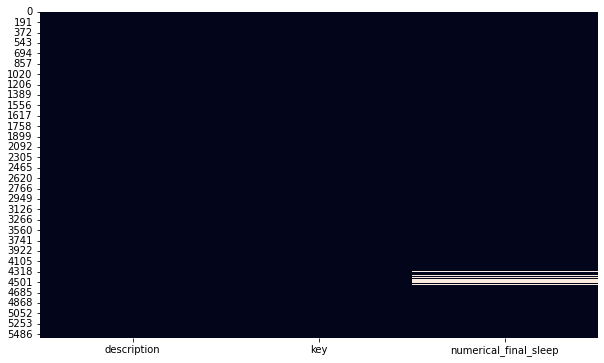

In [16]:
plt.figure(figsize=(10,6))
sns.heatmap(surveydf2.isnull(), cbar=False)

surveydf2[surveydf2.isna().any(axis=1)]

In [17]:
import itertools
missing_sleep_1991 = surveydf2[surveydf2['key'].str.contains(r'1991')].mean()
missing_sleep_1991 = [missing_sleep_1991[1]]
missing_sleep_1995 =[5.5,7] # typo
missing_sleep_2064 = surveydf2[surveydf2['key'].str.contains(r'2064')].mean(skipna=True)
missing_sleep_2064=[missing_sleep_2064[1]]*30

sleep_values_to_add = missing_sleep_1991+missing_sleep_1995+missing_sleep_2064

C:\Users\Mark\AppData\Local\Temp/ipykernel_22516/3177584957.py:2: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  missing_sleep_1991 = surveydf2[surveydf2['key'].str.contains(r'1991')].mean()
C:\Users\Mark\AppData\Local\Temp/ipykernel_22516/3177584957.py:5: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  missing_sleep_2064 = surveydf2[surveydf2['key'].str.contains(r'2064')].mean(skipna=True)


In [18]:
temp_rows = surveydf2[surveydf2.isna().any(axis=1)].index
for i in sleep_values_to_add:
    surveydf2.loc[temp_rows,'numerical_final_sleep'] = sleep_values_to_add

<AxesSubplot:>

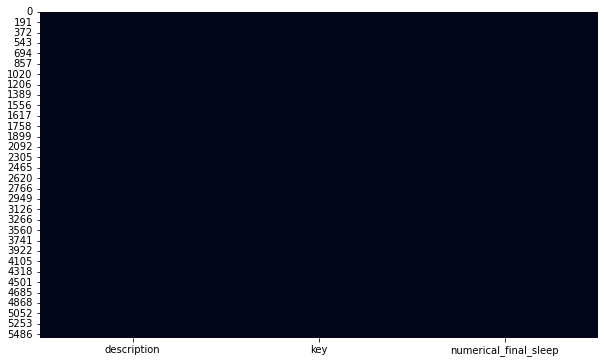

In [19]:
plt.figure(figsize=(10,6))
sns.heatmap(surveydf2.isnull(), cbar=False)

## Read in Garmin Data

In [20]:
garmin = pd.read_csv('garmindata.csv')

#how many observations
print(garmin.SubjectID.count())
#unique ID
print(len(pd.unique(garmin['SubjectID'])))

garmin.head()

6412029
38


,Unnamed: 0,Unnamed: 0.1,filename,record.altitude[m],record.distance[m],record.heart_rate[bpm],record.position_lat[semicircles],record.position_long[semicircles],record.speed[m/s],record.timestamp[s],SubjectID,Year,Date,DataSource
0,5,5,58_20180916_garmindata.csv,1117.2,3.17,78.0,609492677.0,-1.361950e+09,1.465,0.0,58,2018,916,garmindata.csv
1,6,6,58_20180916_garmindata.csv,1116.4,7.93,78.0,609493159.0,-1.361951e+09,2.305,2.0,58,2018,916,garmindata.csv
2,7,7,58_20180916_garmindata.csv,1116.2,10.39,82.0,609493416.0,-1.361951e+09,2.454,3.0,58,2018,916,garmindata.csv
3,8,8,58_20180916_garmindata.csv,1116.2,12.91,86.0,609493682.0,-1.361951e+09,2.463,4.0,58,2018,916,garmindata.csv
4,9,9,58_20180916_garmindata.csv,1116.0,15.66,86.0,609493973.0,-1.361951e+09,2.547,5.0,58,2018,916,garmindata.csv


In [21]:
#Lets explore this data

#Drop 2 first columns
garmin.drop(garmin.columns[[0, 1]], axis=1, inplace=True)

In [22]:
#Create key variables

#For a unique observation, we can make a key variable concatenating  (SubjectID, Year and Date)
cols = ['SubjectID', 'Year', 'Date'] #This key variable might help to find same observation in the survey database
garmin['key'] = garmin[cols].apply(lambda row: '_'.join(row.values.astype(str)), axis=1)

#unique ID
print(len(pd.unique(garmin['key'])))
#average observations per runner
print(len(pd.unique(garmin['key']))/37)
#data per observation
garmin.groupby('key')['SubjectID'].count()


1657
44.78378378378378


key
1942_2017_1008    15052
1942_2017_621      2455
1942_2017_624      3926
1942_2017_706      5375
1942_2017_708      7214
                  ...  
58_2018_910         773
58_2018_913         667
58_2018_915         779
58_2018_916         886
58_2018_924         549
Name: SubjectID, Length: 1657, dtype: int64

In [23]:
#average data per observation
sum(garmin.groupby('key')['SubjectID'].count())/len(garmin.groupby('key')['SubjectID'].count())


3869.661436330718

In [24]:
garmin.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6412029 entries, 0 to 6412028
Data columns (total 13 columns):
 #   Column                             Dtype  
---  ------                             -----  
 0   filename                           object 
 1   record.altitude[m]                 float64
 2   record.distance[m]                 float64
 3   record.heart_rate[bpm]             float64
 4   record.position_lat[semicircles]   float64
 5   record.position_long[semicircles]  float64
 6   record.speed[m/s]                  float64
 7   record.timestamp[s]                float64
 8   SubjectID                          int64  
 9   Year                               int64  
 10  Date                               int64  
 11  DataSource                         object 
 12  key                                object 
dtypes: float64(7), int64(3), object(3)
memory usage: 636.0+ MB


In [25]:
garmin.columns

Index(['filename', 'record.altitude[m]', 'record.distance[m]',
       'record.heart_rate[bpm]', 'record.position_lat[semicircles]',
       'record.position_long[semicircles]', 'record.speed[m/s]',
       'record.timestamp[s]', 'SubjectID', 'Year', 'Date', 'DataSource',
       'key'],
      dtype='object')

In [26]:
garmin = garmin[['SubjectID', 'Year', 'Date', 'key', 'record.altitude[m]', 'record.distance[m]',
       'record.heart_rate[bpm]', 'record.position_lat[semicircles]',
       'record.position_long[semicircles]', 'record.speed[m/s]',
       'record.timestamp[s]']]

## Join garmin and surveydf tables - inner join for match on key with data from surveydf

In [27]:
combined_workout= garmin.merge(surveydf1, on = 'key', how = 'left')
combined_workout = combined_workout.dropna()
combined_workout.head(5)

,SubjectID,Year,Date,key,record.altitude[m],record.distance[m],record.heart_rate[bpm],record.position_lat[semicircles],record.position_long[semicircles],record.speed[m/s],record.timestamp[s],description,numerical_final_workout
2406,58,2018,522,58_2018_522,1026.0,31.21,110.0,609035059.0,-1.361008e+09,2.715,0.0,RPE scale 1-10 of workout difficulty,3.0
2407,58,2018,522,58_2018_522,1026.0,45.74,107.0,609035398.0,-1.361011e+09,2.846,6.0,RPE scale 1-10 of workout difficulty,3.0
2408,58,2018,522,58_2018_522,1026.0,58.16,111.0,609035621.0,-1.361013e+09,2.883,11.0,RPE scale 1-10 of workout difficulty,3.0
2409,58,2018,522,58_2018_522,1026.0,62.44,118.0,609035727.0,-1.361014e+09,2.827,13.0,RPE scale 1-10 of workout difficulty,3.0
2410,58,2018,522,58_2018_522,1026.0,64.00,124.0,609035748.0,-1.361014e+09,2.790,14.0,RPE scale 1-10 of workout difficulty,3.0


In [28]:
combined_sleep = garmin.merge(surveydf2, on = 'key', how = 'left')
combined_sleep= combined_sleep.dropna()
combined_sleep.head(5)

,SubjectID,Year,Date,key,record.altitude[m],record.distance[m],record.heart_rate[bpm],record.position_lat[semicircles],record.position_long[semicircles],record.speed[m/s],record.timestamp[s],description,numerical_final_sleep
886,58,2017,729,58_2017_729,1003.4,1.72,97.0,607370226.0,-1.360298e+09,1.642,0.0,Numeric answer for number of hours of sleep fo...,7.5
887,58,2017,729,58_2017_729,1003.4,3.42,97.0,607370061.0,-1.360298e+09,1.642,1.0,Numeric answer for number of hours of sleep fo...,7.5
888,58,2017,729,58_2017_729,1003.4,20.37,98.0,607368405.0,-1.360297e+09,2.566,8.0,Numeric answer for number of hours of sleep fo...,7.5
889,58,2017,729,58_2017_729,1003.6,41.56,100.0,607367928.0,-1.360294e+09,2.650,16.0,Numeric answer for number of hours of sleep fo...,7.5
890,58,2017,729,58_2017_729,1003.4,61.90,101.0,607367668.0,-1.360290e+09,2.613,24.0,Numeric answer for number of hours of sleep fo...,7.5


### If we look at combined descriptions, match on same SubjectIDs and Keys to find Subjects that have entries for both descriptions (Sleep and Workout)

In [29]:
combined_workout2 = combined_workout.drop_duplicates(subset=['key', 'numerical_final_workout'])

In [30]:
combined_workout2[['key', 'numerical_final_workout']]

,key,numerical_final_workout
2406,58_2018_522,3.0
3314,58_2018_618,2.0
9743,58_2018_714,3.0
12313,58_2018_708,4.0
12891,58_2018_616,4.0
...,...,...
6030383,2067_2018_516,3.0
6031589,2067_2018_829,4.0
6037645,2067_2018_519,8.0
6039400,2067_2018_720,3.0


In [31]:
total_combined = pd.merge(combined_sleep, combined_workout2[['key', 'numerical_final_workout']], on='key')
total_combined.key.unique()

array(['58_2018_522', '58_2018_618', '58_2018_714', '58_2018_708',
       '58_2018_616', '58_2018_806', '58_2018_813', '58_2018_707',
       '58_2018_609', '58_2018_526', '58_2018_811', '58_2018_716',
       '58_2018_818', '58_2018_527', '58_2018_704', '58_2018_820',
       '58_2018_721', '58_2018_519', '424_2018_815', '424_2018_903',
       '424_2018_618', '424_2018_808', '424_2018_617', '424_2018_602',
       '424_2018_524', '424_2018_806', '424_2018_813', '424_2018_809',
       '424_2018_523', '424_2018_801', '424_2018_707', '424_2018_712',
       '424_2018_611', '424_2018_604', '424_2018_521', '424_2018_606',
       '424_2018_526', '424_2018_609', '424_2018_717', '424_2018_702',
       '424_2018_601', '424_2018_614', '424_2018_804', '424_2018_615',
       '424_2018_704', '424_2018_607', '424_2018_528', '424_2018_901',
       '424_2018_802', '424_2018_909', '424_2018_719', '424_2018_730',
       '424_2018_722', '424_2018_628', '424_2018_620', '424_2018_825',
       '424_2018_724', '

<AxesSubplot:>

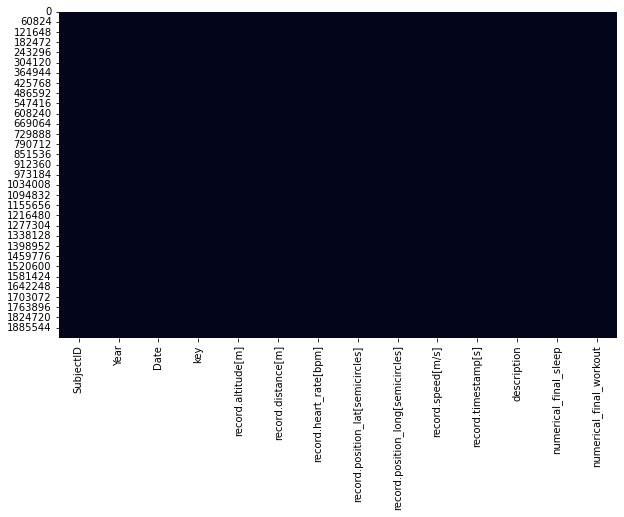

In [32]:
plt.figure(figsize=(10,6))
sns.heatmap(total_combined.isnull(), cbar=False)


In [33]:
total_combined.drop(['record.position_lat[semicircles]',
                    'record.position_long[semicircles]',
                    'description'],axis=1,inplace=True)

In [34]:
total_combined.head(10)

,SubjectID,Year,Date,key,record.altitude[m],record.distance[m],record.heart_rate[bpm],record.speed[m/s],record.timestamp[s],numerical_final_sleep,numerical_final_workout
0,58,2018,522,58_2018_522,1026.0,31.21,110.0,2.715,0.0,7.5,3.0
1,58,2018,522,58_2018_522,1026.0,45.74,107.0,2.846,6.0,7.5,3.0
2,58,2018,522,58_2018_522,1026.0,58.16,111.0,2.883,11.0,7.5,3.0
3,58,2018,522,58_2018_522,1026.0,62.44,118.0,2.827,13.0,7.5,3.0
4,58,2018,522,58_2018_522,1026.0,64.00,124.0,2.790,14.0,7.5,3.0
5,58,2018,522,58_2018_522,1026.0,65.44,124.0,2.715,15.0,7.5,3.0
6,58,2018,522,58_2018_522,1026.0,69.12,127.0,2.594,17.0,7.5,3.0
7,58,2018,522,58_2018_522,1026.0,70.95,130.0,2.566,18.0,7.5,3.0
8,58,2018,522,58_2018_522,1026.0,75.97,136.0,2.575,20.0,7.5,3.0
9,58,2018,522,58_2018_522,1026.0,78.84,139.0,2.613,21.0,7.5,3.0


In [35]:
total_combined.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1946355 entries, 0 to 1946354
Data columns (total 11 columns):
 #   Column                   Dtype  
---  ------                   -----  
 0   SubjectID                int64  
 1   Year                     int64  
 2   Date                     int64  
 3   key                      object 
 4   record.altitude[m]       float64
 5   record.distance[m]       float64
 6   record.heart_rate[bpm]   float64
 7   record.speed[m/s]        float64
 8   record.timestamp[s]      float64
 9   numerical_final_sleep    float64
 10  numerical_final_workout  float64
dtypes: float64(7), int64(3), object(1)
memory usage: 178.2+ MB


In [39]:
# total_combined.to_csv('garmin_sub.csv',index=False)

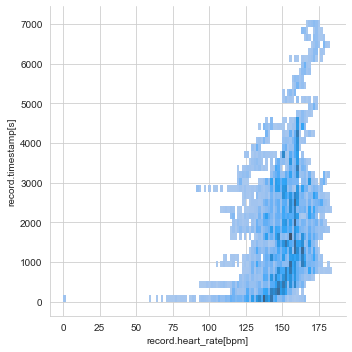

In [36]:
# sns.set_style("whitegrid")
# subject58 = total_combined[total_combined['SubjectID']==58]
# subject58
# sns.displot(data=subject58,y="record.timestamp[s]",x='record.heart_rate[bpm]')

In [37]:
total_combined.SubjectID.unique() # 16 runners

array([  58,  424,  429,  514,  517, 1942, 1990, 1991, 1995, 2059, 2060,
       2061, 2064, 2065, 2066, 2067], dtype=int64)

In [56]:
total_combined['pace[min/Km]'] = total_combined['record.timestamp[s]']/total_combined['record.distance[m]']*16.667
total_combined.head()

,SubjectID,Year,Date,key,record.altitude[m],record.distance[m],record.heart_rate[bpm],record.speed[m/s],record.timestamp[s],numerical_final_sleep,numerical_final_workout,pace[min/Km]
0,58,2018,522,58_2018_522,1026.0,31.21,110.0,2.715,0.0,7.5,3.0,0.000000
1,58,2018,522,58_2018_522,1026.0,45.74,107.0,2.846,6.0,7.5,3.0,2.186314
2,58,2018,522,58_2018_522,1026.0,58.16,111.0,2.883,11.0,7.5,3.0,3.152287
3,58,2018,522,58_2018_522,1026.0,62.44,118.0,2.827,13.0,7.5,3.0,3.470067
4,58,2018,522,58_2018_522,1026.0,64.00,124.0,2.790,14.0,7.5,3.0,3.645906


In [60]:
total_combined.describe()

,SubjectID,Year,Date,record.altitude[m],record.distance[m],record.heart_rate[bpm],record.speed[m/s],record.timestamp[s],numerical_final_sleep,numerical_final_workout,pace[min/Km]
count,1.946355e+06,1946355.0,1.946355e+06,1.946355e+06,1.946355e+06,1.946355e+06,1.946355e+06,1.946355e+06,1.946355e+06,1.946355e+06,1.946237e+06
mean,1.653138e+03,2018.0,7.330917e+02,1.048261e+03,6.049287e+03,1.254448e+02,2.202540e+00,2.774059e+03,7.017084e+00,3.490851e+00,inf
std,6.819362e+02,0.0,1.599226e+02,2.425314e+02,5.927488e+03,4.122487e+01,5.811681e-01,2.718047e+03,1.342923e+00,1.384933e+00,NaN
min,5.800000e+01,2018.0,4.300000e+02,-1.080000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00
25%,1.942000e+03,2018.0,6.090000e+02,1.042400e+03,2.085050e+03,1.220000e+02,2.015000e+00,9.680000e+02,6.383333e+00,3.000000e+00,7.105289e+00
50%,2.059000e+03,2018.0,7.180000e+02,1.072200e+03,4.248520e+03,1.340000e+02,2.258000e+00,1.963000e+03,7.000000e+00,3.000000e+00,7.707111e+00
75%,2.064000e+03,2018.0,8.250000e+02,1.116000e+03,7.876215e+03,1.470000e+02,2.491000e+00,3.545000e+03,8.000000e+00,4.000000e+00,8.247725e+00
max,2.067000e+03,2018.0,1.031000e+03,2.275600e+03,5.449489e+04,2.140000e+02,6.550000e+00,2.579600e+04,1.180000e+01,8.000000e+00,inf


In [67]:
total_combined[(total_combined == np.inf).any(axis=1)]

,SubjectID,Year,Date,key,record.altitude[m],record.distance[m],record.heart_rate[bpm],record.speed[m/s],record.timestamp[s],numerical_final_sleep,numerical_final_workout,pace[min/Km]
819555,1995,2018,519,1995_2018_519,1044.2,0.0,76.0,2.417,45.0,7.0,3.0,inf
1734645,2065,2018,903,2065_2018_903,1044.8,0.0,158.0,2.109,1.0,7.0,2.0,inf


In [73]:
total_combined['pace[min/Km]'].replace(np.inf, 0,inplace=True)

In [74]:
total_combined.describe()

,SubjectID,Year,Date,record.altitude[m],record.distance[m],record.heart_rate[bpm],record.speed[m/s],record.timestamp[s],numerical_final_sleep,numerical_final_workout,pace[min/Km]
count,1.946355e+06,1946355.0,1.946355e+06,1.946355e+06,1.946355e+06,1.946355e+06,1.946355e+06,1.946355e+06,1.946355e+06,1.946355e+06,1.946237e+06
mean,1.653138e+03,2018.0,7.330917e+02,1.048261e+03,6.049287e+03,1.254448e+02,2.202540e+00,2.774059e+03,7.017084e+00,3.490851e+00,7.860312e+00
std,6.819362e+02,0.0,1.599226e+02,2.425314e+02,5.927488e+03,4.122487e+01,5.811681e-01,2.718047e+03,1.342923e+00,1.384933e+00,5.127333e+00
min,5.800000e+01,2018.0,4.300000e+02,-1.080000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00
25%,1.942000e+03,2018.0,6.090000e+02,1.042400e+03,2.085050e+03,1.220000e+02,2.015000e+00,9.680000e+02,6.383333e+00,3.000000e+00,7.105288e+00
50%,2.059000e+03,2018.0,7.180000e+02,1.072200e+03,4.248520e+03,1.340000e+02,2.258000e+00,1.963000e+03,7.000000e+00,3.000000e+00,7.707111e+00
75%,2.064000e+03,2018.0,8.250000e+02,1.116000e+03,7.876215e+03,1.470000e+02,2.491000e+00,3.545000e+03,8.000000e+00,4.000000e+00,8.247724e+00
max,2.067000e+03,2018.0,1.031000e+03,2.275600e+03,5.449489e+04,2.140000e+02,6.550000e+00,2.579600e+04,1.180000e+01,8.000000e+00,8.455692e+02


In [76]:
distance_bins = [0,5137.28,25000]
total_combined["binned_dist"] = pd.cut(total_combined['record.distance[m]'], distance_bins)

#bin the sleep survey datatable
sleep_bins = [0,5,8,18]
total_combined["binned_sleep"] = pd.cut(total_combined['numerical_final_sleep'], sleep_bins)
total_combined.head()

,SubjectID,Year,Date,key,record.altitude[m],record.distance[m],record.heart_rate[bpm],record.speed[m/s],record.timestamp[s],numerical_final_sleep,numerical_final_workout,pace[min/Km],binned_dist,binned_sleep
0,58,2018,522,58_2018_522,1026.0,31.21,110.0,2.715,0.0,7.5,3.0,0.000000,"(0.0, 5137.28]","(5, 8]"
1,58,2018,522,58_2018_522,1026.0,45.74,107.0,2.846,6.0,7.5,3.0,2.186314,"(0.0, 5137.28]","(5, 8]"
2,58,2018,522,58_2018_522,1026.0,58.16,111.0,2.883,11.0,7.5,3.0,3.152287,"(0.0, 5137.28]","(5, 8]"
3,58,2018,522,58_2018_522,1026.0,62.44,118.0,2.827,13.0,7.5,3.0,3.470067,"(0.0, 5137.28]","(5, 8]"
4,58,2018,522,58_2018_522,1026.0,64.00,124.0,2.790,14.0,7.5,3.0,3.645906,"(0.0, 5137.28]","(5, 8]"


In [78]:
total_combined['binned_sleep'].value_counts()

(5, 8]     1621368
(8, 18]     186730
(0, 5]      131899
Name: binned_sleep, dtype: int64

In [79]:
total_combined['binned_dist'].value_counts()

(0.0, 5137.28]        1131310
(5137.28, 25000.0]     782645
Name: binned_dist, dtype: int64